# Data Exploration: Merged 3D MedMNIST Datasets

This notebook explores the **5 merged 3D MedMNIST datasets** used for hierarchical classification:
- **OrganMNIST3D**: Multi-organ CT scans (11 classes)
- **NoduleMNIST3D**: Lung nodules (2 classes: benign/malignant)
- **AdrenalMNIST3D**: Adrenal gland CT scans (2 classes)
- **FractureMNIST3D**: Rib fractures (3 classes)
- **VesselMNIST3D**: Brain vessel MRA (2 classes)

In [1]:
import sys
import os
sys.path.insert(0, '..')
from medmnist import INFO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from config import DEVICE, DATA_CONFIG, DEFAULT_MERGED_DATASETS, set_seed
from utils.data_loader import create_hierarchical_dataset, REGION_DATASET_MAPPING

set_seed(42)
print(f"Device: {DEVICE}")

No GPU detected, using CPU
Device: cpu


In [2]:
# Map short names to INFO keys
DATASET_INFO_KEYS = {
    'organ': 'organmnist3d',
    'nodule': 'nodulemnist3d',
    'adrenal': 'adrenalmnist3d',
    'fracture': 'fracturemnist3d',
    'vessel': 'vesselmnist3d',
}
print('='*60)
print('CLASS LABELS FOR EACH DATASET SUBSET')
print('='*60)
for short_name, info_key in DATASET_INFO_KEYS.items():
    info = INFO[info_key]
    
    # Create DataFrame for this dataset
    labels_data = []
    for label_idx, label_name in info['label'].items():
        labels_data.append({
            'Index': label_idx,
            'Label Name': label_name
        })
    
    df = pd.DataFrame(labels_data)
    
    # Print header
    print(f"\n{short_name.upper()} ({info_key}) - Task: {info.get('task', 'N/A')}")
    
    # Display styled table
    display(
        df.style
        .hide(axis="index")
        .set_properties(subset=['Index'], **{'text-align': 'center'})
        .set_properties(subset=['Label Name'], **{'text-align': 'left'})
        .set_table_styles([
            {'selector': 'th.col0', 'props': [('text-align', 'center')]},
            {'selector': 'th.col1', 'props': [('text-align', 'left')]}
        ])
    )

CLASS LABELS FOR EACH DATASET SUBSET

ORGAN (organmnist3d) - Task: multi-class


Index,Label Name
0,liver
1,kidney-right
2,kidney-left
3,femur-right
4,femur-left
5,bladder
6,heart
7,lung-right
8,lung-left
9,spleen



NODULE (nodulemnist3d) - Task: binary-class


Index,Label Name
0,benign
1,malignant



ADRENAL (adrenalmnist3d) - Task: binary-class


Index,Label Name
0,normal
1,hyperplasia



FRACTURE (fracturemnist3d) - Task: multi-class


Index,Label Name
0,buckle rib fracture
1,nondisplaced rib fracture
2,displaced rib fracture



VESSEL (vesselmnist3d) - Task: binary-class


Index,Label Name
0,vessel
1,aneurysm


## 1. Load Merged Dataset

In [3]:
# Load all 5 merged datasets
train_loader, val_loader, test_loader, dataset_info = create_hierarchical_dataset(
    datasets_to_include=DEFAULT_MERGED_DATASETS,
    batch_size=DATA_CONFIG['batch_size'],
    num_workers=DATA_CONFIG['num_workers']
)

print("="*60)
print("MERGED DATASET INFO")
print("="*60)

# 1. Basic info table
basic_info = pd.DataFrame([{
    'Coarse Classes': dataset_info['num_coarse_classes'],
    'Fine Classes': dataset_info['num_fine_classes'],
    'Train Samples': dataset_info['train_samples'],
    'Val Samples': dataset_info['val_samples'],
    'Test Samples': dataset_info['test_samples']
}])
print("\nDataset Overview:")
display(
    basic_info.style
    .hide(axis="index")
    .set_properties(**{'text-align': 'center'})
)

# 2. Region mapping table
region_rows = []
for region, idx in dataset_info['region_to_idx'].items():
    region_rows.append({
        'Region': region.upper(),
        'Index': idx,
        'Fine Classes': dataset_info['region_num_classes'][region]
    })

df_regions = pd.DataFrame(region_rows)
print("\nCoarse Regions:")
display(
    df_regions.style
    .hide(axis="index")
    .set_properties(subset=['Region'], **{'text-align': 'left'})
    .set_properties(subset=['Index', 'Fine Classes'], **{'text-align': 'center'})
    .set_table_styles([
        {'selector': 'th.col0', 'props': [('text-align', 'left')]},
        {'selector': 'th.col1', 'props': [('text-align', 'center')]},
        {'selector': 'th.col2', 'props': [('text-align', 'center')]}
    ])
)

# 3. Detailed fine label mapping per region
from medmnist import INFO
DATASET_INFO_KEYS = {
    'organ': 'organmnist3d', 'nodule': 'nodulemnist3d', 
    'adrenal': 'adrenalmnist3d', 'fracture': 'fracturemnist3d', 'vessel': 'vesselmnist3d'
}

print("\nFine Label Mapping by Region:")
for region in ['abdomen', 'chest', 'brain']:
    fine_map = dataset_info['region_fine_label_map'][region]
    rows = []
    for (dataset, orig_idx), local_idx in sorted(fine_map.items(), key=lambda x: x[1]):
        # Get real label name from INFO
        info_key = DATASET_INFO_KEYS[dataset]
        label_name = INFO[info_key]['label'][str(orig_idx)]
        rows.append({
            'Local Index': local_idx,
            'Dataset': dataset.upper(),
            'Original Index': orig_idx,
            'Label Name': label_name
        })
    
    df_fine = pd.DataFrame(rows)
    print(f"\n{region.upper()} ({len(rows)} classes):")
    display(
        df_fine.style
        .hide(axis="index")
        .set_properties(subset=['Local Index', 'Dataset', 'Original Index'], **{'text-align': 'center'})
        .set_properties(subset=['Label Name'], **{'text-align': 'left'})
        .set_table_styles([
            {'selector': 'th.col0', 'props': [('text-align', 'center')]},
            {'selector': 'th.col1', 'props': [('text-align', 'center')]},
            {'selector': 'th.col2', 'props': [('text-align', 'center')]},
            {'selector': 'th.col3', 'props': [('text-align', 'left')]}
        ])
    )

MERGED DATASET INFO

Dataset Overview:


Coarse Classes,Fine Classes,Train Samples,Val Samples,Test Samples
3,20,5679,718,1840



Coarse Regions:


Region,Index,Fine Classes
ABDOMEN,0,10
CHEST,1,8
BRAIN,2,2



Fine Label Mapping by Region:

ABDOMEN (10 classes):


Local Index,Dataset,Original Index,Label Name
0,ADRENAL,0,normal
1,ADRENAL,1,hyperplasia
2,ORGAN,0,liver
3,ORGAN,1,kidney-right
4,ORGAN,2,kidney-left
5,ORGAN,3,femur-right
6,ORGAN,4,femur-left
7,ORGAN,5,bladder
8,ORGAN,9,spleen
9,ORGAN,10,pancreas



CHEST (8 classes):


Local Index,Dataset,Original Index,Label Name
0,FRACTURE,0,buckle rib fracture
1,FRACTURE,1,nondisplaced rib fracture
2,FRACTURE,2,displaced rib fracture
3,NODULE,0,benign
4,NODULE,1,malignant
5,ORGAN,6,heart
6,ORGAN,7,lung-right
7,ORGAN,8,lung-left



BRAIN (2 classes):


Local Index,Dataset,Original Index,Label Name
0,VESSEL,0,vessel
1,VESSEL,1,aneurysm


## 2. Data Distribution

In [4]:
DATASET_INFO_KEYS = {
    'organ': 'organmnist3d', 'nodule': 'nodulemnist3d', 
    'adrenal': 'adrenalmnist3d', 'fracture': 'fracturemnist3d', 'vessel': 'vesselmnist3d'
}

all_coarse_labels = []
all_fine_labels_by_region = {region: [] for region in dataset_info['idx_to_region'].values()}

for imgs, coarse, fine in train_loader:
    for i in range(len(coarse)):
        region_idx = coarse[i].item()
        region_name = dataset_info['idx_to_region'][region_idx]
        all_coarse_labels.append(region_idx)
        all_fine_labels_by_region[region_name].append(fine[i].item())

coarse_counts = Counter(all_coarse_labels)

# Display Coarse Distribution
print("\nCoarse (Region) Distribution:")
coarse_rows = []
for idx, count in sorted(coarse_counts.items()):
    region = dataset_info['idx_to_region'][idx]
    pct = 100 * count / len(all_coarse_labels)
    coarse_rows.append({'Region': region.upper(), 'Index': idx, 'Count': count, 'Percentage': f"{pct:.1f}%"})

df_coarse = pd.DataFrame(coarse_rows)
display(
    df_coarse.style
    .hide(axis="index")
    .set_properties(subset=['Region'], **{'text-align': 'left'})
    .set_properties(subset=['Index', 'Count', 'Percentage'], **{'text-align': 'center'})
    .set_table_styles([
        {'selector': 'th.col0', 'props': [('text-align', 'left')]},
        {'selector': 'th.col1', 'props': [('text-align', 'center')]},
        {'selector': 'th.col2', 'props': [('text-align', 'center')]},
        {'selector': 'th.col3', 'props': [('text-align', 'center')]}
    ])
)

# Display Fine Label Distribution (per region)
print("\nFine Label Distribution (by Region):")
for region in ['abdomen', 'chest', 'brain']:
    fine_counts = Counter(all_fine_labels_by_region[region])
    fine_map = dataset_info['region_fine_label_map'][region]
    
    rows = []
    for (dataset, orig_idx), local_idx in sorted(fine_map.items(), key=lambda x: x[1]):
        info_key = DATASET_INFO_KEYS[dataset]
        label_name = INFO[info_key]['label'][str(orig_idx)]
        count = fine_counts.get(local_idx, 0)
        total = len(all_fine_labels_by_region[region])
        pct = 100 * count / total if total > 0 else 0
        rows.append({
            'Local Index': local_idx,
            'Dataset': dataset.upper(),
            'Label Name': label_name,
            'Count': count,
            'Percentage': f"{pct:.1f}%"
        })
    
    df_fine = pd.DataFrame(rows)
    print(f"\n{region.upper()} ({len(rows)} classes, {len(all_fine_labels_by_region[region])} samples):")
    display(
        df_fine.style
        .hide(axis="index")
        .set_properties(subset=['Local Index', 'Dataset', 'Count', 'Percentage'], **{'text-align': 'center'})
        .set_properties(subset=['Label Name'], **{'text-align': 'left'})
        .set_table_styles([
            {'selector': 'th.col0', 'props': [('text-align', 'center')]},
            {'selector': 'th.col1', 'props': [('text-align', 'center')]},
            {'selector': 'th.col2', 'props': [('text-align', 'left')]},
            {'selector': 'th.col3', 'props': [('text-align', 'center')]},
            {'selector': 'th.col4', 'props': [('text-align', 'center')]}
        ])
    )

c:\Users\BS-06\Desktop\HMIC\HierarchicalMIC\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Coarse (Region) Distribution:


Region,Index,Count,Percentage
ABDOMEN,0,2041,35.9%
CHEST,1,2303,40.6%
BRAIN,2,1335,23.5%



Fine Label Distribution (by Region):

ABDOMEN (10 classes, 2041 samples):


Local Index,Dataset,Label Name,Count,Percentage
0,ADRENAL,normal,929,45.5%
1,ADRENAL,hyperplasia,259,12.7%
2,ORGAN,liver,115,5.6%
3,ORGAN,kidney-right,115,5.6%
4,ORGAN,kidney-left,115,5.6%
5,ORGAN,femur-right,91,4.5%
6,ORGAN,femur-left,93,4.6%
7,ORGAN,bladder,94,4.6%
8,ORGAN,spleen,115,5.6%
9,ORGAN,pancreas,115,5.6%



CHEST (8 classes, 2303 samples):


Local Index,Dataset,Label Name,Count,Percentage
0,FRACTURE,buckle rib fracture,473,20.5%
1,FRACTURE,nondisplaced rib fracture,383,16.6%
2,FRACTURE,displaced rib fracture,171,7.4%
3,NODULE,benign,863,37.5%
4,NODULE,malignant,295,12.8%
5,ORGAN,heart,40,1.7%
6,ORGAN,lung-right,39,1.7%
7,ORGAN,lung-left,39,1.7%



BRAIN (2 classes, 1335 samples):


Local Index,Dataset,Label Name,Count,Percentage
0,VESSEL,vessel,1185,88.8%
1,VESSEL,aneurysm,150,11.2%


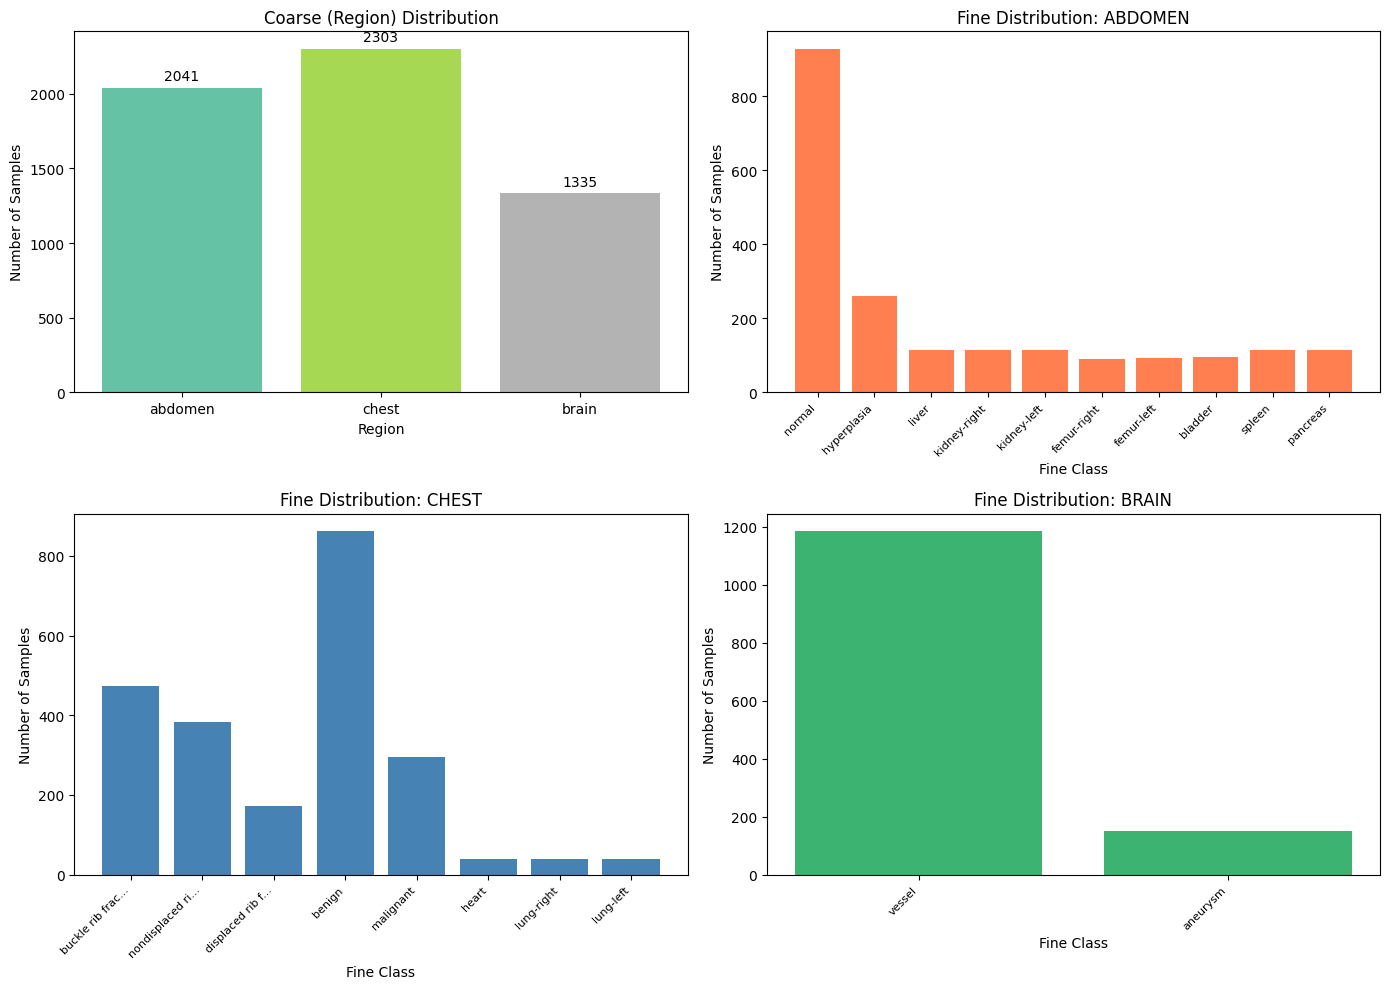

In [5]:
DATASET_INFO_KEYS = {
    'organ': 'organmnist3d', 'nodule': 'nodulemnist3d', 
    'adrenal': 'adrenalmnist3d', 'fracture': 'fracturemnist3d', 'vessel': 'vesselmnist3d'
}
# Ensure figures directory exists
figures_dir = '../figures'
os.makedirs(figures_dir, exist_ok=True)
# Create figure with 4 subplots: 1 for coarse, 3 for fine (one per region)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
# --- Coarse distribution ---
regions = [dataset_info['idx_to_region'][i] for i in sorted(coarse_counts.keys())]
counts = [coarse_counts[i] for i in sorted(coarse_counts.keys())]
colors = plt.cm.Set2(np.linspace(0, 1, len(regions)))
axes[0].bar(regions, counts, color=colors)
axes[0].set_xlabel('Region')
axes[0].set_ylabel('Number of Samples')
axes[0].set_title('Coarse (Region) Distribution')
for i, (r, c) in enumerate(zip(regions, counts)):
    axes[0].text(i, c + 50, str(c), ha='center', fontsize=10)
# --- Fine distribution per region ---
region_colors = {'abdomen': 'coral', 'chest': 'steelblue', 'brain': 'mediumseagreen'}
for ax_idx, region in enumerate(['abdomen', 'chest', 'brain'], start=1):
    fine_counts_region = Counter(all_fine_labels_by_region[region])
    fine_map = dataset_info['region_fine_label_map'][region]
    
    # Get labels in order of local index
    labels = []
    counts_list = []
    for (dataset, orig_idx), local_idx in sorted(fine_map.items(), key=lambda x: x[1]):
        info_key = DATASET_INFO_KEYS[dataset]
        label_name = INFO[info_key]['label'][str(orig_idx)]
        # Truncate long labels
        short_label = label_name[:15] + '...' if len(label_name) > 15 else label_name
        labels.append(short_label)
        counts_list.append(fine_counts_region.get(local_idx, 0))
    
    x_pos = range(len(labels))
    axes[ax_idx].bar(x_pos, counts_list, color=region_colors[region])
    axes[ax_idx].set_xlabel('Fine Class')
    axes[ax_idx].set_ylabel('Number of Samples')
    axes[ax_idx].set_title(f'Fine Distribution: {region.upper()}')
    axes[ax_idx].set_xticks(x_pos)
    axes[ax_idx].set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'data_distribution.png'), dpi=150)
plt.show()

## 3. Sample Visualization

In [6]:
def visualize_3d_sample(volume, title="3D Volume", num_slices=6):
    """Visualize slices of a 3D volume."""
    if volume.ndim == 4:  # (C, D, H, W)
        volume = volume[0]  # Take first channel
    
    depth = volume.shape[0]
    slice_indices = np.linspace(0, depth-1, num_slices, dtype=int)
    
    fig, axes = plt.subplots(1, num_slices, figsize=(15, 3))
    for i, idx in enumerate(slice_indices):
        axes[i].imshow(volume[idx], cmap='gray')
        axes[i].set_title(f'Slice {idx}')
        axes[i].axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    return fig

Visualizing samples from each region...



c:\Users\BS-06\Desktop\HMIC\HierarchicalMIC\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


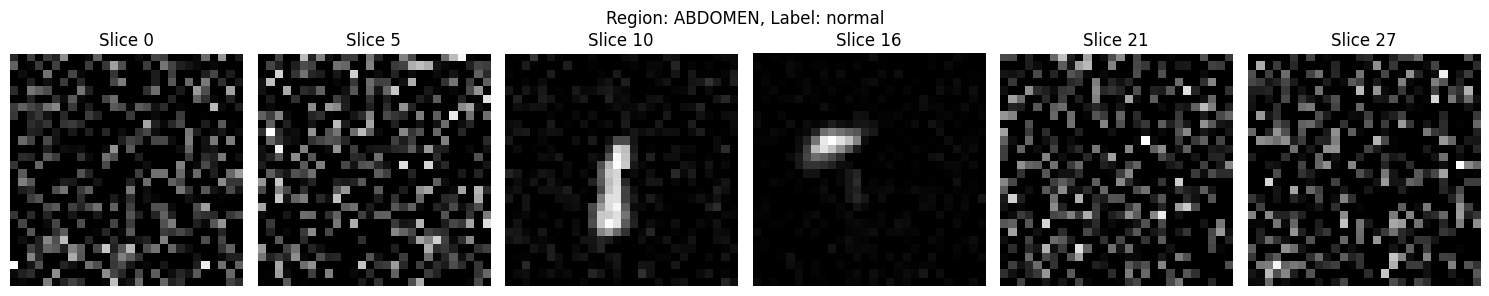

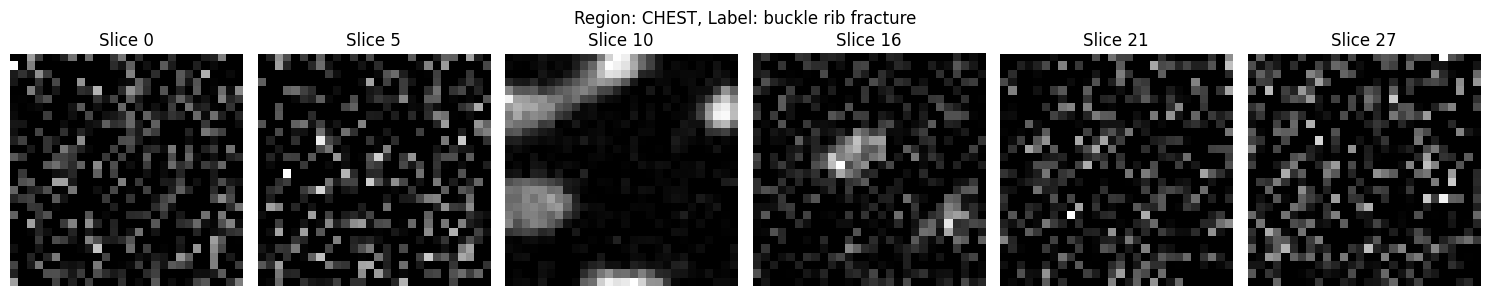

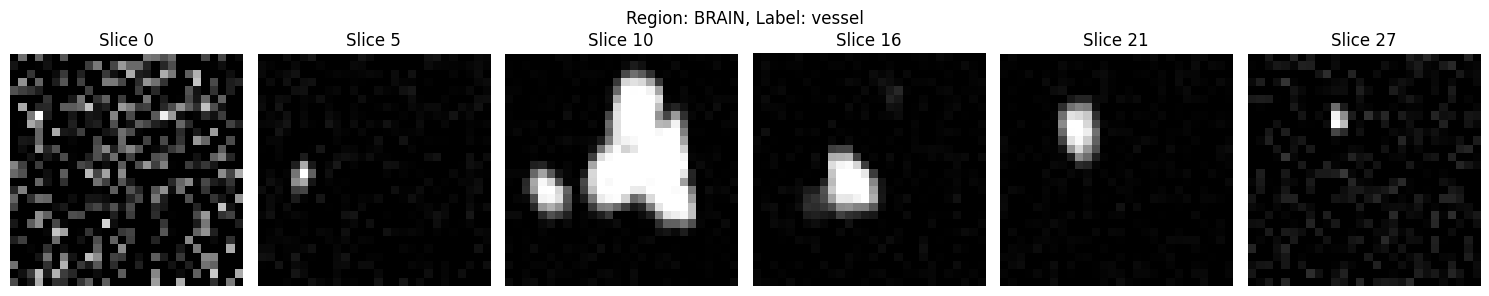

In [7]:
# Visualize samples from each region
print("Visualizing samples from each region...\n")

DATASET_INFO_KEYS = {
    'organ': 'organmnist3d', 'nodule': 'nodulemnist3d', 
    'adrenal': 'adrenalmnist3d', 'fracture': 'fracturemnist3d', 'vessel': 'vesselmnist3d'
}

region_samples = {region: None for region in dataset_info['idx_to_region'].values()}

for imgs, coarse, fine in train_loader:
    for i in range(len(imgs)):
        region_idx = coarse[i].item()
        region_name = dataset_info['idx_to_region'][region_idx]
        if region_samples[region_name] is None:
            region_samples[region_name] = (imgs[i].numpy(), fine[i].item())
    
    if all(v is not None for v in region_samples.values()):
        break

for region, (sample, fine_label) in region_samples.items():
    # Get actual label name from fine_label
    fine_map = dataset_info['region_fine_label_map'][region]
    # Reverse lookup: find (dataset, orig_idx) for this local_idx
    for (dataset, orig_idx), local_idx in fine_map.items():
        if local_idx == fine_label:
            info_key = DATASET_INFO_KEYS[dataset]
            label_name = INFO[info_key]['label'][str(orig_idx)]
            break
    
    fig = visualize_3d_sample(sample, title=f"Region: {region.upper()}, Label: {label_name}")
    plt.show()

## 4. Volume Statistics

In [8]:
# Compute volume statistics
print("Computing volume statistics...")

all_means = []
all_stds = []
sample_count = 0
max_samples = 500  # Limit for speed

for imgs, _, _ in train_loader:
    for img in imgs:
        img_np = img.numpy()
        if img_np.max() > 1:
            img_np = img_np / 255.0
        all_means.append(img_np.mean())
        all_stds.append(img_np.std())
        sample_count += 1
    
    if sample_count >= max_samples:
        break

# Display as styled table
stats_data = [
    {'Statistic': 'Mean Intensity', 'Value': f"{np.mean(all_means):.4f}", 'Std Dev': f"± {np.std(all_means):.4f}"},
    {'Statistic': 'Std Intensity', 'Value': f"{np.mean(all_stds):.4f}", 'Std Dev': f"± {np.std(all_stds):.4f}"}
]

df_stats = pd.DataFrame(stats_data)
print(f"\nVolume Statistics (from {sample_count} samples):")
display(
    df_stats.style
    .hide(axis="index")
    .set_properties(subset=['Statistic'], **{'text-align': 'left'})
    .set_properties(subset=['Value', 'Std Dev'], **{'text-align': 'center'})
    .set_table_styles([
        {'selector': 'th.col0', 'props': [('text-align', 'left')]},
        {'selector': 'th.col1', 'props': [('text-align', 'center')]},
        {'selector': 'th.col2', 'props': [('text-align', 'center')]}
    ])
)

Computing volume statistics...

Volume Statistics (from 504 samples):


Statistic,Value,Std Dev
Mean Intensity,0.1732,± 0.2168
Std Intensity,0.1426,± 0.0682


## 5. Summary

In [9]:
print("\n" + "="*60)
print("DATA EXPLORATION SUMMARY")
print("="*60)

# Dataset Overview
summary_rows = [
    {'Category': 'Datasets', 'Detail': ', '.join(dataset_info['datasets_included'])},
    {'Category': 'Total Samples', 'Detail': f"{dataset_info['train_samples'] + dataset_info['val_samples'] + dataset_info['test_samples']:,}"},
    {'Category': 'Train / Val / Test', 'Detail': f"{dataset_info['train_samples']:,} / {dataset_info['val_samples']:,} / {dataset_info['test_samples']:,}"},
    {'Category': 'Coarse Classes', 'Detail': f"{dataset_info['num_coarse_classes']} (abdomen, chest, brain)"},
    {'Category': 'Fine Classes', 'Detail': f"{dataset_info['num_fine_classes']} (region-local labels)"},
]

df_summary = pd.DataFrame(summary_rows)
print("\nDataset Overview:")
display(
    df_summary.style
    .hide(axis="index")
    .set_properties(subset=['Category'], **{'text-align': 'left'})
    .set_properties(subset=['Detail'], **{'text-align': 'center'})
    .set_table_styles([
        {'selector': 'th.col0', 'props': [('text-align', 'left')]},
        {'selector': 'th.col1', 'props': [('text-align', 'center')]}
    ])
)

print("\n" + "="*60)


DATA EXPLORATION SUMMARY

Dataset Overview:


Category,Detail
Datasets,"organ, nodule, adrenal, fracture, vessel"
Total Samples,"8,237"
Train / Val / Test,"5,679 / 718 / 1,840"
Coarse Classes,"3 (abdomen, chest, brain)"
Fine Classes,20 (region-local labels)
